In [101]:
import sys
sys.path.insert(1, '../')

In [107]:
import LLM_MRI
import matplotlib.pyplot as plt
import os
from datasets import load_dataset, features, ClassLabel

In [134]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"], split='train[:5%]')

In [135]:
# Turning 'label' feature into "ClassLabel" type

label_feature = emotions.features["label"]

class_names  = emotions.unique("label")
class_feature = features.ClassLabel(names=sorted(class_names))
emotions = emotions.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

emotions = emotions.cast(features.Features({
    "label": class_feature,
    "text": emotions.features["text"]}))


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

In [136]:
emotions.features

{'label': ClassLabel(names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], id=None),
 'text': Value(dtype='string', id=None)}

In [137]:
model_ckpt = "distilbert-base-uncased"

In [138]:
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=emotions)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [139]:
llm_mri.process_activation_areas(map_dimension = 10)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/home/lipecorradini/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


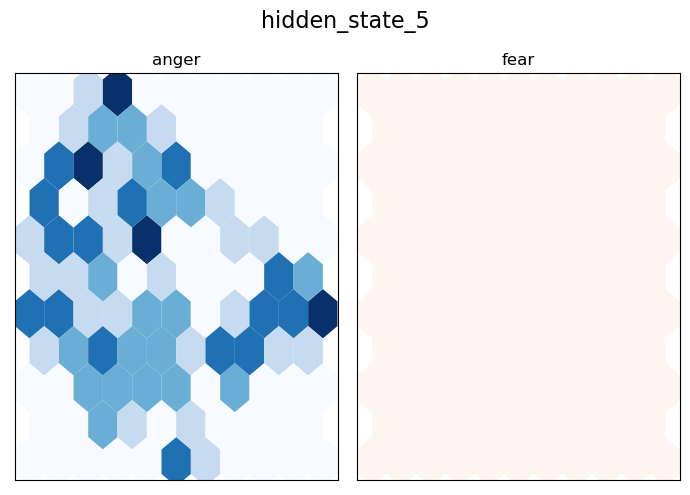

In [140]:
fig = llm_mri.get_layer_image(layer=5, category=0)
plt.tight_layout()
plt.show()

In [ ]:
g_img = llm_mri.get_graph_image(category=0)
plt.box(False)
plt.show()